<a href="https://colab.research.google.com/github/Florian-Debieve/datascience_projects/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spaceship_test.csv to spaceship_test.csv
Saving spaceship_train.csv to spaceship_train.csv


Here we'll participate in a Kaggle competiton: the Spaceship Titanic competiton https://www.kaggle.com/competitions/spaceship-titanic/

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, we are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

In [ ]:
train = pd.read_csv('spaceship_train.csv')
test = pd.read_csv('spaceship_test.csv')

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# **Data preprocessing**

There are several modification that needs to be performed on this dataset. First, the "CryoSleep" and "VIP" columns must be put as booleans. Then, the informations of the "Cabin" column have to be extracted. The "Cabin" column information is presented as a string containing the deck, the cabin number and on which side of the shipe it is located. With it, we will create 2 columns "Deck" and "Side", the cabin number isn't really useful here. Finally, a last column will be created using the "PassengerId" one. As this column shows us if a passenger is a part of a group (boarding with family, friend or else) or not, we'll make a column "NbrGroup" which will contains the number of person in the group that the passenger belongs to. If the passenger is alone, then the value in this column will be equal to "1".

In [ ]:
def prep(df):
  df[['CryoSleep','VIP']] = df[['CryoSleep','VIP']].astype('bool')
  cabin_details = df['Cabin'].str.split('/', expand = True)
  df['Deck'] = cabin_details[0]
  df['Side'] = cabin_details[2]
  id_details = df['PassengerId'].str.split('_', expand = True)
  mapper = id_details.groupby(0).count().to_dict()[1]
  df['NbrGroup'] = id_details[0]
  df['NbrGroup'].replace(mapper, inplace=True)
  return df

In [ ]:
train_p = prep(train)
train_p_X = train_p.drop('Transported', axis = 1)
train_p_y = train_p['Transported']
X_test = prep(test)

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_p_X, train_p_y, test_size=0.2, random_state=15)


In [ ]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Side,NbrGroup
7908,8451_01,Mars,False,F/1625/S,55 Cancri e,31.0,False,1997.0,0.0,0.0,0.0,0.0,Ale Start,F,S,2
5598,5959_02,Europa,True,D/181/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Dabik Praugnox,D,S,2
3299,3543_03,Europa,True,C/116/P,TRAPPIST-1e,56.0,False,0.0,0.0,0.0,0.0,0.0,Elerops Holatirint,C,P,3
2696,2890_02,Europa,True,B/89/P,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,Suhain Cattyried,B,P,2
593,0615_03,Earth,True,G/92/S,55 Cancri e,3.0,False,0.0,0.0,0.0,0.0,0.0,Stance Hodes,G,S,3


Now, we make a pipeline to preprocess the data before using it to create a model.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat_pipeline = Pipeline([
      ("ordinal_encoder", OrdinalEncoder()),
      ("imputer", SimpleImputer(strategy="most_frequent")),
      ("one_hot_encoder", OneHotEncoder(sparse=False))     
    ])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "RoomService", "FoodCourt",	"ShoppingMall",	"Spa", "VRDeck", "NbrGroup"]
cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck",	"Side"]

prep_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])


And we apply the preprocessing:

In [ ]:
X_train = prep_pipeline.fit_transform(X_train)
X_valid = prep_pipeline.fit_transform(X_valid)
X_test = prep_pipeline.fit_transform(X_test)

# **Random Forest**

First, let's make a simple RandomForestClassifier model to see how it performs on the dataset.

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=15)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=15)

In [73]:
from sklearn.metrics import accuracy_score

y_pred = rf.predict(X_train)
print(accuracy_score(y_train, y_pred))

y_pred2 = rf.predict(X_valid)
print(accuracy_score(y_valid, y_pred2))

0.9679321253954558
0.7872340425531915


Even if it is clearly overfitting, the accuracy on the validation set achieve a value of 0.787.

In [74]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_rand = {'n_estimators': randint(low=50, high=1000),
              'min_samples_split': randint(low=2, high=10),
              'max_depth': randint(low=1, high=1000),
              'criterion': ['gini', 'entropy'],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None]
              }


rand_search = RandomizedSearchCV(RandomForestClassifier(random_state=15), param_rand, cv=3,scoring='accuracy')

rand_search.fit(X_train, y_train)
rand_search.best_params_


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 909,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 434}

In [75]:
y_pred = rand_search.best_estimator_.predict(X_train)
print(accuracy_score(y_train, y_pred))

y_pred2 = rand_search.best_estimator_.predict(X_valid)
print(accuracy_score(y_valid, y_pred2))

0.9158757549611735
0.7958596894767107


We succeeded in improving the RandomForestClassifier model, it went from a validation accuracy of 0.787 to one of 0.796.

# **Neural network**

Now, let's make a neural network.

We create a callback to change the learning rate during training.

It will be applied on 1 epoch and will allow us to plot the loss depending on the learning rate, as a result, we will be able to choose an adequat learning rate for the training.

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

We start with a neural network with 2 hidden layers described below:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = [27,]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               8400      
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 99,001
Trainable params: 99,001
Non-trainable params: 0
_________________________________________________________________


Below, we are using the "expon_lr" callback to modify the learning rate during training as explained earlier.

We choose a starting learning rate of 5e-6 and a factor of 1.081. It will make the learning rate varies from 5e-6 to approximately 120 during the 1 epoch the training will run.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6
                                    )
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.081)

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid)
                    ,callbacks=[expon_lr]
                    )

218/218 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.5518 - val_loss: nan - val_accuracy: 0.5210


Text(0, 0.5, 'Loss')

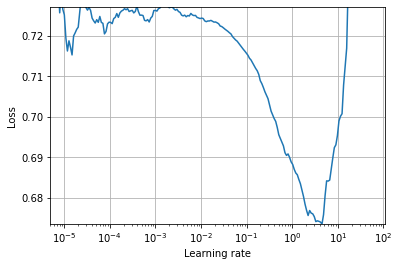

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.axis([min(expon_lr.rates), max(expon_lr.rates), min(expon_lr.losses), expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

With the graph above we choose to use a learning rate equal to 1.

We now make an early stopping callback that will stop the training if there is no more improvement of the validation loss with a patience of 5 epochs.

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = [27,]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb
                              ]
                    )

Epoch 1/30
218/218 [==============================] - 1s 5ms/step - loss: 0.4665 - accuracy: 0.7692 - val_loss: 0.6383 - val_accuracy: 0.7096
Epoch 2/30
218/218 [==============================] - 1s 4ms/step - loss: 0.4301 - accuracy: 0.7954 - val_loss: 0.4148 - val_accuracy: 0.8039
Epoch 3/30
218/218 [==============================] - 1s 4ms/step - loss: 0.4188 - accuracy: 0.7947 - val_loss: 0.4244 - val_accuracy: 0.7970
Epoch 4/30
218/218 [==============================] - 1s 4ms/step - loss: 0.4145 - accuracy: 0.8004 - val_loss: 0.4291 - val_accuracy: 0.7947
Epoch 5/30
218/218 [==============================] - 1s 4ms/step - loss: 0.4087 - accuracy: 0.8074 - val_loss: 0.5500 - val_accuracy: 0.7217
Epoch 6/30
218/218 [==============================] - 1s 4ms/step - loss: 0.4060 - accuracy: 0.8057 - val_loss: 0.4400 - val_accuracy: 0.7711
Epoch 7/30
218/218 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8056 - val_loss: 0.4455 - val_accuracy: 0.8010


The accuracy on the validation data is of 0.8039 which is better than the RandomForestClassifier used earlier.

We don't really know what parameters are the best to choose in order to get the best neural network. So let's write a script that will create neural network with random parameters and test them.

It is possible to do that here because the dataset we got is relatively small, so it won't take a lot of time to test several models.

In [ ]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(15)

In [ ]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=5, default=2)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    hidden_layer_neurons = []
    for i in range(n_hidden):
        hidden_layer_neurons.append(hp.Int("n_neurons_" + str(i), min_value=50, max_value=400))
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [27,]))
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(hidden_layer_neurons[i], activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=20, overwrite=True,
    directory="my_spaceship", project_name="my_rnd_search", seed=15)
random_search_tuner.search(X_train, y_train, epochs=100,
                           validation_data=(X_valid, y_valid),callbacks=[early_stopping_cb])


Trial 20 Complete [00h 00m 42s]
val_accuracy: 0.623346745967865

Best val_accuracy So Far: 0.8119608759880066
Total elapsed time: 00h 08m 00s


In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
print(top3_params[0].values)
print(top3_params[1].values)
print(top3_params[2].values)

{'n_hidden': 5, 'learning_rate': 7.48862598186336e-05, 'optimizer': 'adam', 'n_neurons_0': 374, 'n_neurons_1': 300, 'n_neurons_2': 182, 'n_neurons_3': 312, 'n_neurons_4': 277}
{'n_hidden': 2, 'learning_rate': 0.0002761974894983277, 'optimizer': 'adam', 'n_neurons_0': 173, 'n_neurons_1': 242, 'n_neurons_2': 73, 'n_neurons_3': 224, 'n_neurons_4': 135}
{'n_hidden': 1, 'learning_rate': 0.004181120947645292, 'optimizer': 'adam', 'n_neurons_0': 206, 'n_neurons_1': 217, 'n_neurons_2': 195, 'n_neurons_3': 74, 'n_neurons_4': 76}


The best model gotten from the random model builder is the one summarized below. It has 5 hidden layers, was trained using Adam optimizer with a learning rate of 7.48862598186336e-05.

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 374)               10472     
                                                                 
 dense_1 (Dense)             (None, 300)               112500    
                                                                 
 dense_2 (Dense)             (None, 182)               54782     
                                                                 
 dense_3 (Dense)             (None, 312)               57096     
                                                                 
 dense_4 (Dense)             (None, 277)               86701     
                                                                 
 dense_5 (Dense)             (None, 1)                 278       
                                                                 
Total params: 321,829
Trainable params: 321,829
Non-trai

In [52]:
y_pred = best_model.predict(X_train).reshape(-1) > 0.5
print(accuracy_score(y_train, y_pred))

y_pred2 = best_model.predict(X_valid).reshape(-1) > 0.5
print(accuracy_score(y_valid, y_pred2))

218/218 [==============================] - 0s 2ms/step
0.8224043715846995
55/55 [==============================] - 0s 3ms/step
0.8269120184013801


The validation accuracy of this model a greatly improved as it is of 0.827, and we can see that the model is not overfitting.

We didn't include it but we also tested several other configurations.

Let's also keep the second best model we got (described below), it was trained with the Adam optimizer and a learning rate of 0.0002761974894983277.

In [57]:
second_model = top3_models[1]
second_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 173)               4844      
                                                                 
 dense_1 (Dense)             (None, 242)               42108     
                                                                 
 dense_2 (Dense)             (None, 1)                 243       
                                                                 
Total params: 47,195
Trainable params: 47,195
Non-trainable params: 0
_________________________________________________________________


In [56]:
y_pred = second.predict(X_train).reshape(-1) > 0.5
print(accuracy_score(y_train, y_pred))

y_pred2 = second.predict(X_valid).reshape(-1) > 0.5
print(accuracy_score(y_valid, y_pred2))

218/218 [==============================] - 0s 1ms/step
0.822260569456428
55/55 [==============================] - 0s 1ms/step
0.8085106382978723


In [68]:
nn_type = type(best_model) #variable to characterize a neural network model, used later

# **Ensemble**

In order to improve the quality of our predictions, let's try to make ensemble. It means that we'll combine several models together to perform the classification task.

Let's write functions that will perform the predictions by the ensemble and also create a submission that can be send to Kaggle.

In [ ]:
def predictions_stack(X,models): # compute the predictions of the models and stack them together into a same numpy array
  predictions = []
  for m in models:
  # the post processing of the predictions is different depending on the model type (neural network or random forest)  
    if type(m) == nn_type:
      predictions.append(m.predict(X).reshape(-1))
    else:
      predictions.append(m.predict_proba(X)[:,1])
  predictions = np.stack(predictions, axis=1)
  return predictions

def get_final_prediction(X, models, threshold): # combine the predictions together and output the result
  predictions = predictions_stack(X, models)
  final_prediction = np.sum(predictions, axis=1)/ len(models) > threshold
  return final_prediction

def get_submission(X, models, threshold, to_csv = True): # make a csv file out of the final predictions to submit to Kaggle
  final_predictions = get_final_prediction(X, models, threshold)
  results = pd.Series(final_predictions,name="Transported")
  submission = pd.DataFrame(test["PassengerId"])
  submission['Transported'] = results
  if to_csv == True:
    submission.to_csv("submission.csv",index=False)
  return submission

Let's combine the best neural network and the best random forest classifier together first, then the best and the second best neural network and finally, the 3 of them together.

In [76]:
y_pred = get_final_prediction(X_train, [best_model,rand_search.best_estimator_], 0.5)
print(accuracy_score(y_train, y_pred))

y_pred2 = get_final_prediction(X_valid, [best_model,rand_search.best_estimator_], 0.5)
print(accuracy_score(y_valid, y_pred2))

218/218 [==============================] - 1s 2ms/step
0.8717285015818234
55/55 [==============================] - 0s 3ms/step
0.8085106382978723


In [71]:
y_pred = get_final_prediction(X_train, [best_model,second_model], 0.5)
print(accuracy_score(y_train, y_pred))

y_pred2 = get_final_prediction(X_valid, [best_model,second_model], 0.5)
print(accuracy_score(y_valid, y_pred2))

218/218 [==============================] - 0s 2ms/step
0.8232671843543284
55/55 [==============================] - 0s 2ms/step
0.8177113283496262


In [77]:
y_pred = get_final_prediction(X_train, [best_model,second_model,rand_search.best_estimator_], 0.5)
print(accuracy_score(y_train, y_pred))

y_pred2 = get_final_prediction(X_valid, [best_model,second_model,rand_search.best_estimator_], 0.5)
print(accuracy_score(y_valid, y_pred2))

218/218 [==============================] - 0s 1ms/step
0.8569168823698591
55/55 [==============================] - 0s 1ms/step
0.8125359401955147


From the results above, we can see that there is no improvement with an ensemble. We'll now only consider the ensemble using the 2 neural networks.

Let's see if we can combine 2 models more intelligently by applying weights to their predictions. To do that, we create the 2 following functions for that.

In [78]:
def get_final_prediction_weighted(X, models, threshold, a):
  predictions = predictions_stack(X, models)
  final_prediction = np.average(predictions, axis=1, weights=[a, 1-a]) > threshold
  return final_prediction

def get_submission_weighted(X, models, threshold, a, to_csv = True):
  final_predictions = get_final_prediction_weighted(X, models, threshold, a)
  results = pd.Series(final_predictions,name="Transported")
  submission = pd.DataFrame(test["PassengerId"])
  submission['Transported'] = results
  if to_csv == True:
    submission.to_csv("submission.csv",index=False)
  return submission

In [85]:
def weight_graph(X, y, models):
  acc = []
  alpha = []
  for a in np.linspace(0,1,100):
    alpha.append(a)
    acc.append(accuracy_score(y,get_final_prediction_weighted(X, models, 0.5, a)))
  plt.plot(alpha, acc)
  best_index = np.argmax(acc)
  best_alpha = alpha[best_index]
  plt.scatter(best_alpha, np.max(acc), color='red')
  plt.annotate(f'Max accuracy: {np.max(acc)} for an alpha of {best_alpha}', (best_alpha,np.max(acc)), textcoords="offset points", xytext=(0,10), ha='center')
  plt.xlabel('Alpha')
  plt.ylabel('Accuracy')
  plt.gca().set_frame_on(False)
  plt.show()

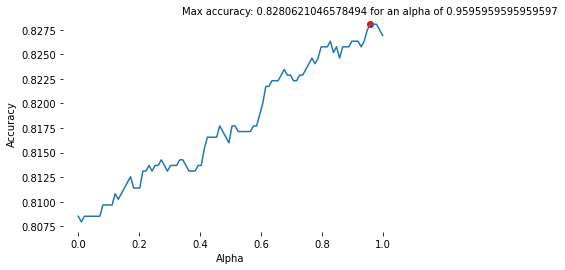

In [86]:
weight_graph(X_valid, y_valid, [best_model,second_model])

It looks like the best model is the most important and that there is not really a point into adding another model in the equation.

Let's see if this is confirmed when we do that on different section of the validation set.

In [124]:
X_valid1 = X_valid[:X_valid.shape[0]//3]
X_valid2 = X_valid[X_valid.shape[0]//3:2*X_valid.shape[0]//3]
X_valid3 = X_valid[2*X_valid.shape[0]//3:]
y_v = np.array(y_valid)

y_valid1 = y_v[:y_v.shape[0]//3]
y_valid2 = y_v[y_v.shape[0]//3:2*y_v.shape[0]//3]
y_valid3 = y_v[2*y_v.shape[0]//3:]

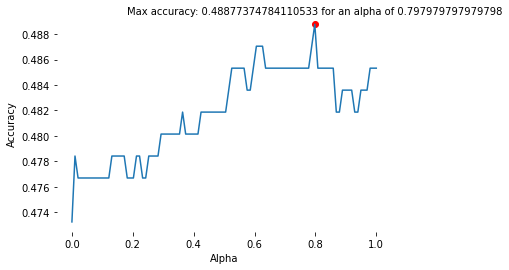

In [117]:
weight_graph(X_valid1, y_valid1, [best_model,second_model])

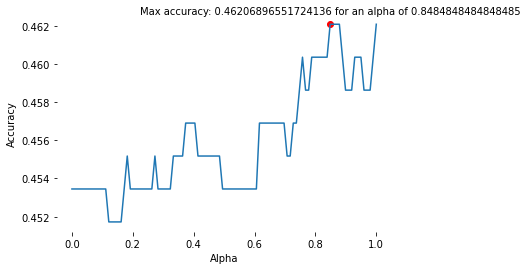

In [118]:
weight_graph(X_valid2, y_valid2, [best_model,second_model])

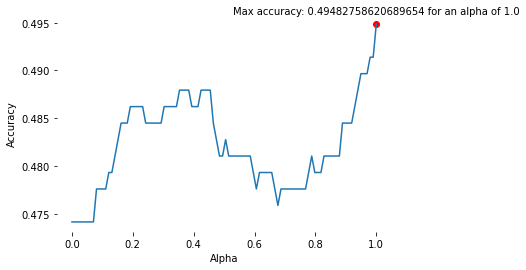

In [126]:
weight_graph(X_valid3, y_valid3, [best_model,second_model])

There is no real pattern that we can spot on these 3 graphs. If we try to choose a value for alpha it will most likely just be an overfit to the validation set.

As a result, we decide to use only the best neural network for our predictions.

Now, let's see if we can choose a different threshold to our prediction.

In [130]:
def threshold_graph(X, y, models):
  dict = {}
  for t in [round(float(x * 0.05),2) for x in range(1, 20)]:
    pred = get_final_prediction(X,models,t)
    dict[t] = accuracy_score(y, pred)
  x = list(dict.keys())
  y = list(dict.values())
  x_max = x[np.argmax(y)]
  y_max = round(y[np.argmax(y)],6)
  plt.plot(x, y)
  plt.scatter(x_max, y_max, color='red')
  plt.annotate(f'Max accuracy: {y_max} for a threshold of {x_max}', (x_max, y_max), textcoords="offset points", xytext=(0,10), ha='center')
  plt.xlabel('Threshold')
  plt.ylabel('Accuracy')
  plt.gca().set_frame_on(False)
  plt.show()

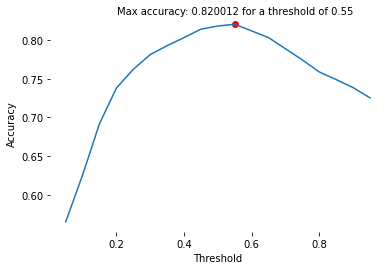

In [65]:
threshold_graph(X_valid, y_valid, [best_model, second_model])

As before, let's see if this value is not an overfit.

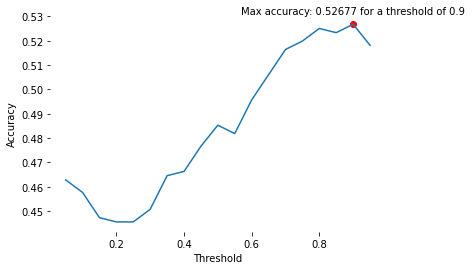

In [131]:
threshold_graph(X_valid1, y_valid1, [best_model])

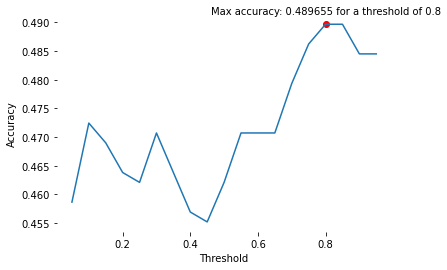

In [132]:
threshold_graph(X_valid2, y_valid2, [best_model])

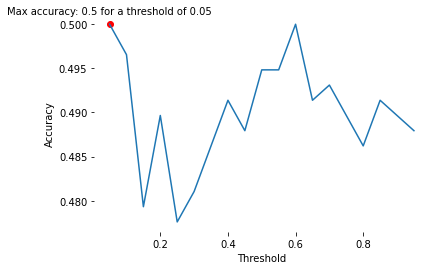

In [133]:
threshold_graph(X_valid3, y_valid3, [best_model])

As for the alpha value, choosing a different threshold value doesn't look like a good idea. We'll keep it at 0.5.

# **Conclusion**

Let's make the submission to Kaggle.

In [135]:
submission = get_submission(X_test,[best_model],0.5,True)

134/134 [==============================] - 1s 5ms/step


With this submission we got a score of 0.80196 on Kaggle !

In the leaderboard it results in a position of 634th out of 2409 at the moment of writing this.

Knowing that the best score is 0.85527 and that the 4th position has already dropped at 0.81833, it is not a bad score.

We could improve the score by possibly preprocessing more thoroughly the data and by maybe adding some columns.